# Question 1.d

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

torch.set_printoptions(precision=10)
torch.__version__

'0.3.1.post2'

## Load train and test dataset

In [2]:
class OccupancyDataset(Dataset):
    """ Occupancy detection dataset"""
    
    def __init__(self, filename):
        self.dataset = np.loadtxt(filename, skiprows=1, dtype = object, delimiter=',')
        
        self.data = np.array(self.dataset[:,2:7], dtype = float)
        self.data = (self.data - self.data.mean())/self.data.std()
        self.data = torch.from_numpy(self.data).float()
        
        self.target = np.array(self.dataset[:,7], dtype = float)
        self.target = torch.from_numpy(self.target).float()
        
    def __len__(self):
        return self.data.size()[0]
    
    def __getitem__(self, idx):
        return (self.data[idx, :], self.target[idx])

    
# Setup datasets and loaders
train_dataset = OccupancyDataset('train_data.txt')
test_dataset = OccupancyDataset('test_data.txt')

## Create network class

In [3]:
class Net(nn.Module):
    """ Neural network with 1 hidden layer and sigmoid activations """
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(5,5)
        self.fc2 = nn.Linear(5,1)
        
    def forward(self, x):
        #print(x)
        x = F.sigmoid(self.fc1(x))
        return F.sigmoid(self.fc2(x))
    
n = Net()
print(n)
#print(list( n.parameters()) )

Net(
  (fc1): Linear(in_features=5, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)


## Train function

In [4]:
def train(epoch):
    # Train the network
    running_loss = 0
    count = 0
    for i, data in enumerate(train_loader, 0):
        optimizer.zero_grad()
        inputs, target = data
        inputs, target = Variable(inputs), Variable(target.float())
        output = net(inputs).squeeze()
        loss =  criterion(output, target)     
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0]
        count +=1

    return running_loss/count
    
    
def get_acc(loader, dataset):
    # Get accuracy (%) for train/test
    correct = 0
    total = 0
    for i, data in enumerate(loader, 0):
        inputs, target = data
        inputs, target = Variable(inputs), Variable(target.float())
        output = net(inputs).squeeze()
        output = output>0.5
        correct += (target.data.cpu().numpy() == output.data.cpu().numpy()).sum()
        total += target.size(0)
    return 100*int(correct)/int(total)

def run_optimizer():
    losses = []
    accuracy = []
    final_epoch = 0

    # Run epochs and store necessary metrics
    for i in range(epochs):
        loss = train(i)
        losses.append(loss)
        train_acc = get_acc(train_loader, 'Train')
        test_acc = get_acc(test_loader, 'Test')
        accuracy.append(test_acc)
        if i%100==0:
            print('\n')
            print('Loss after epoch {1}: {0}'.format(loss, i))
            print('Train Accuracy: {0}'.format(train_acc))
            print('Test Accuracy: {0}'.format(test_acc))

            # Stop training based on below condition
        if i>200 and accuracy[i]-accuracy[i-50] < 1e-2:
            print('Reached local minima at epoch: {0} with error: {1}'.format(i, accuracy[i]))
            final_epoch = i
            break
    return accuracy, final_epoch
    

## Setting variables for SGD

In [11]:
train_batch_size = 100
test_batch_size = 100

train_loader = DataLoader(train_dataset, batch_size = train_batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size= test_batch_size, shuffle = False)

net = Net()
print(list(net.parameters()))
epochs = 2000
lr = 0.001
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
criterion = nn.BCELoss()

[Parameter containing:
-0.0727616251 0.0083447099 -0.0498761535 -0.3524668813 -0.2259062976
-0.1580338776 0.1237648129 -0.3148422539 0.1666700244 0.0377391875
0.2100751996 0.4354951382 -0.0606210530 -0.0083136261 0.3940888047
0.3157782555 0.4004745483 0.2149344683 -0.0354786515 0.2187737226
-0.3324247599 -0.2260354310 0.2284352779 0.0175635815 -0.0797688067
[torch.FloatTensor of size 5x5]
, Parameter containing:
0.3398510814
0.0684273839
0.4123148918
0.3936618567
-0.2815660834
[torch.FloatTensor of size 5]
, Parameter containing:
-0.3918961287 0.0942075253 0.3612582684 0.1120766997 0.0496871173
[torch.FloatTensor of size 1x5]
, Parameter containing:
1.00000e-02 *
 -4.0749371052
[torch.FloatTensor of size 1]
]


## Running SGD

In [12]:
accuracy_sgd, epoch_sgd = run_optimizer()



Loss after epoch 0: 0.6503413675761804
Train Accuracy: 78.76703917475132
Test Accuracy: 78.98892534864643


Loss after epoch 100: 0.0910328578249347
Train Accuracy: 98.83335380081051
Test Accuracy: 97.84659557013946


Loss after epoch 200: 0.06441977084046457
Train Accuracy: 98.83335380081051
Test Accuracy: 98.31829368334701
Reached local minima at epoch: 201 with error: 98.31829368334701


## Setting parameters for Batch Gradient decent

In [7]:
train_batch_size = len(train_dataset)
test_batch_size = len(test_dataset)

train_loader = DataLoader(train_dataset, batch_size = train_batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size= test_batch_size, shuffle = False)

net = Net()
print(list(net.parameters()))
epochs = 2000
lr = 0.0001
optimizer = optim.SGD(net.parameters(), lr=lr)
criterion = nn.BCELoss()

[Parameter containing:
0.3546487689 -0.1442515552 0.4399570823 -0.0572826862 -0.0822196603
0.3918565512 -0.0908726752 -0.3169617653 0.4008457065 0.3009217381
-0.0041321218 0.4359288812 0.0120881200 0.2100175023 -0.2865144610
-0.0483578742 -0.0319072008 0.2352747321 0.4022808075 0.0038635135
-0.1788521707 0.2339725494 -0.1365017891 -0.0530630350 0.4461079240
[torch.FloatTensor of size 5x5]
, Parameter containing:
-0.0175494552
-0.2346861511
-0.2007555068
0.0219481885
-0.2673647106
[torch.FloatTensor of size 5]
, Parameter containing:
-0.1170531511 -0.4130647779 0.3499189615 -0.4324310124 0.0602083206
[torch.FloatTensor of size 1x5]
, Parameter containing:
-0.4355434179
[torch.FloatTensor of size 1]
]


## Running Batch gradient descent

In [8]:
accuracy_batch, epoch_batch = run_optimizer()



Loss after epoch 0: 0.5600675940513611
Train Accuracy: 78.76703917475132
Test Accuracy: 78.98892534864643


Loss after epoch 100: 0.5598685145378113
Train Accuracy: 78.76703917475132
Test Accuracy: 78.98892534864643


Loss after epoch 200: 0.5596728920936584
Train Accuracy: 78.76703917475132
Test Accuracy: 78.98892534864643
Reached local minima at epoch: 201 with error: 78.98892534864643


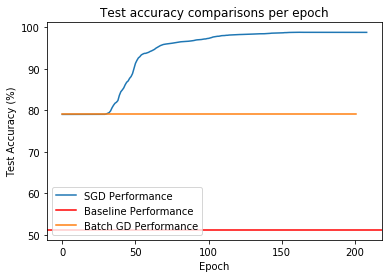

In [9]:
# Plot performance comparison of SGD and Batch gradient descent

plt.figure()
plt.title('Test accuracy comparisons per epoch')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.plot(range(epoch_sgd+1), accuracy_sgd, label = 'SGD Performance')

# Plot baseline train accuracy 48.827
plt.axhline(y=51.173, color='r', linestyle='-', label = 'Baseline Performance')

plt.plot(range(epoch_batch+1), accuracy_batch, label = 'Batch GD Performance')

plt.legend()
#plt.plot( range)


### Observations

    - Batch gradient descent gets stuck at a local minima/saddle point and fails to get out it.
    - SGD is able to get out of it after few epochs and go to a better local minima.